In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4403839%2F7563141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240316%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240316T005111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D822a4959d5bfcd9de164fb55e8045de76f2bd9f059e17244f97268821c4c95e81efe4ae92db3f24329834069a75e2583c9ee3ca4610774b16951ff756e8f3dcafe6bf187eea69fbb07d1761d522ea258af037c31ffdc75d422a0cb7080e2f9f6c87fb94a22b729ca475c1cc40ec96a224b2650bb5560695d1121e07e00e94f4bf451b0c8517e92ad17f250a4b198660cf6e67fe1ab942ef3d6e410b6446f912bbfb10500b7bd1f7894a2d06d0a63b7c42d5e3c917c24477f576ad3090405acbe1cca1b4f0fece00b6e00e6f0b41aa6251aa8b8f11faf9b422a9be070166caf78d19cb304678f9ba88aeb6e8e74cf4e2e9b4c300439702f18b5178a398dd802bb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# DATA PROCESSING
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import train_test_split
import os
data = None
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data = pd.read_csv(os.path.join(dirname, filename))


In [ ]:
print(f"Example of data: \n {data.head()}")
print(np.shape(data.text))
print(np.shape(data.label))
data.label.value_counts()

Example of data: 
    Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4
(416809,)
(416809,)


label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

text_data = data.text
label_data = data.label

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

stemmer=PorterStemmer()
def word_stemmers(text):
    word=word_tokenize(text)
    stem_words = [stemmer.stem(words) for words in word]
    return " ".join(stem_words)

text_data = text_data.apply(word_stemmers)
text_data = text_data.apply(remove_special_characters)
text_data = text_data.apply(remove_stopwords)

print(text_data.head())

0                     feel realli helpless heavi heart
1    ive enjoy abl slouch relax unwind frankli need...
2                 gave internship dmrg feel distraught
3                                  dont know feel lost
4    kindergarten teacher thoroughli weari job take...
Name: text, dtype: object


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.85, min_df=2)
# Fit the vectorizer on the tweets: learns the vocabulary and idf of each term
text_in_tfidf = vectorizer.fit_transform(text_data)
# Convert the TF-IDF matrix to a dense format and display it
feature_names = vectorizer.get_feature_names_out()
print(np.shape(text_in_tfidf))
print(np.shape(feature_names))
print(feature_names[:100])

(416809, 25908)
(25908,)
['aa' 'aaa' 'aaaaall' 'aaaaand' 'aaaahhhhhh' 'aaaand' 'aaah' 'aaargh'
 'aabsolut' 'aac' 'aactual' 'aah' 'aahhh' 'aakash' 'aand' 'aaron' 'aat'
 'ab' 'aback' 'abah' 'abandon' 'abang' 'abash' 'abat' 'abaya' 'abba'
 'abbey' 'abbi' 'abbott' 'abbrevi' 'abc' 'abdomen' 'abdomin' 'abduct'
 'abdul' 'abe' 'abel' 'abelard' 'abercrombi' 'aberr' 'abey' 'abhi'
 'abhilasha' 'abhor' 'abhorr' 'abi' 'abid' 'abigail' 'abil' 'abilit'
 'abit' 'abject' 'abl' 'ablaz' 'abliti' 'abnorm' 'abo' 'aboard' 'abod'
 'abolish' 'abolitionist' 'abomin' 'aborigin' 'abort' 'abot' 'abotu'
 'abou' 'abound' 'abov' 'abraham' 'abram' 'abras' 'abreast' 'abroad'
 'abrupt' 'abruptli' 'abscenc' 'absenc' 'absent' 'absente' 'absentia'
 'absentmindedli' 'absinth' 'absolout' 'absolut' 'absoluteti' 'absolutley'
 'absolutli' 'absolv' 'absorb' 'absorpt' 'absoult' 'abstain' 'abstract'
 'absurd' 'absurdli' 'abt' 'abu' 'abuja' 'abund']


In [ ]:
#Model Training
# Calculate indices for splits
size = len(text_data)
index_60 = int(size* 0.6)  # 60% of the data
index_80 = int(size* 0.8)  # 80% of the data (60% + 20%)

# Split the data
X_train = text_in_tfidf[:index_60]        # Top 60%
X_val = text_in_tfidf[index_60:index_80]  # Middle 20%
X_test = text_in_tfidf[index_80:]      # Last 20%

y_train = label_data[:index_60]
y_val = label_data[index_60:index_80]
y_test = label_data[index_80:]

In [ ]:
print(len(y_train))
print(y_train.value_counts())

250085
label
1    84716
0    73007
3    34278
4    28532
2    20534
5     9018
Name: count, dtype: int64


In [ ]:
print(len(y_val))
print(y_val.value_counts())

83362
label
1    28058
0    24066
3    11465
4     9686
2     7107
5     2980
Name: count, dtype: int64


In [ ]:
print(len(y_test))
print(y_test.value_counts())

83362
label
1    28293
0    24114
3    11574
4     9494
2     6913
5     2974
Name: count, dtype: int64


In [ ]:
#Model Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import time    # this is an inbuilt library in Python

start_time = time.time()
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=20,max_features='sqrt', random_state=42)
# Train the classifier
rf_classifier.fit(X_train, y_train)
# Predict on the test set
y_pred = rf_classifier.predict(X_val)
end_time = time.time()
# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Execution time: ", end_time - start_time,"secs")


Accuracy: 0.8365202370384588
Execution time:  662.3841247558594 secs


In [ ]:
#Model Assessment
start_time = time.time()
y_pred_test = rf_classifier.predict(X_test)
end_time = time.time()
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Execution time: ", end_time - start_time,"secs")

Accuracy: 0.8391473333173388
Execution time:  2.4077837467193604 secs


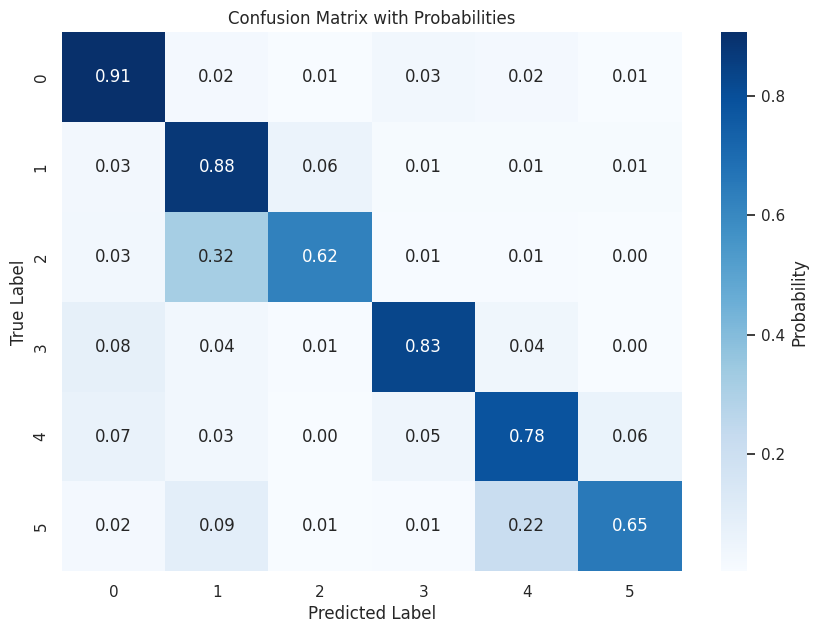

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_test)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
prob_conf_matrix = conf_matrix / row_sums
plt.figure(figsize=(10,7))
sns.heatmap(prob_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Probability'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Probabilities')
plt.show()